Linear Regression MSE: 1.8808661128633724e+16
Linear Regression R²: 0.058281513449454314
Gradient Boosting MSE: 1.5043414453462502e+16
Gradient Boosting R²: 0.2468011734178982


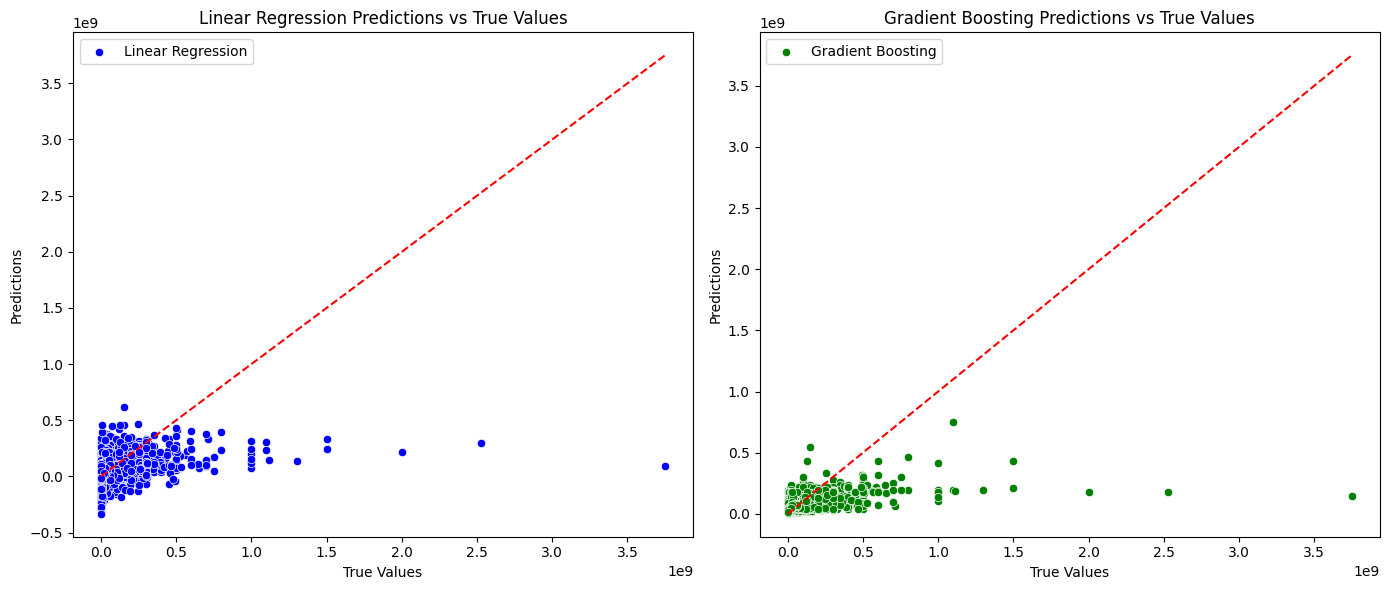

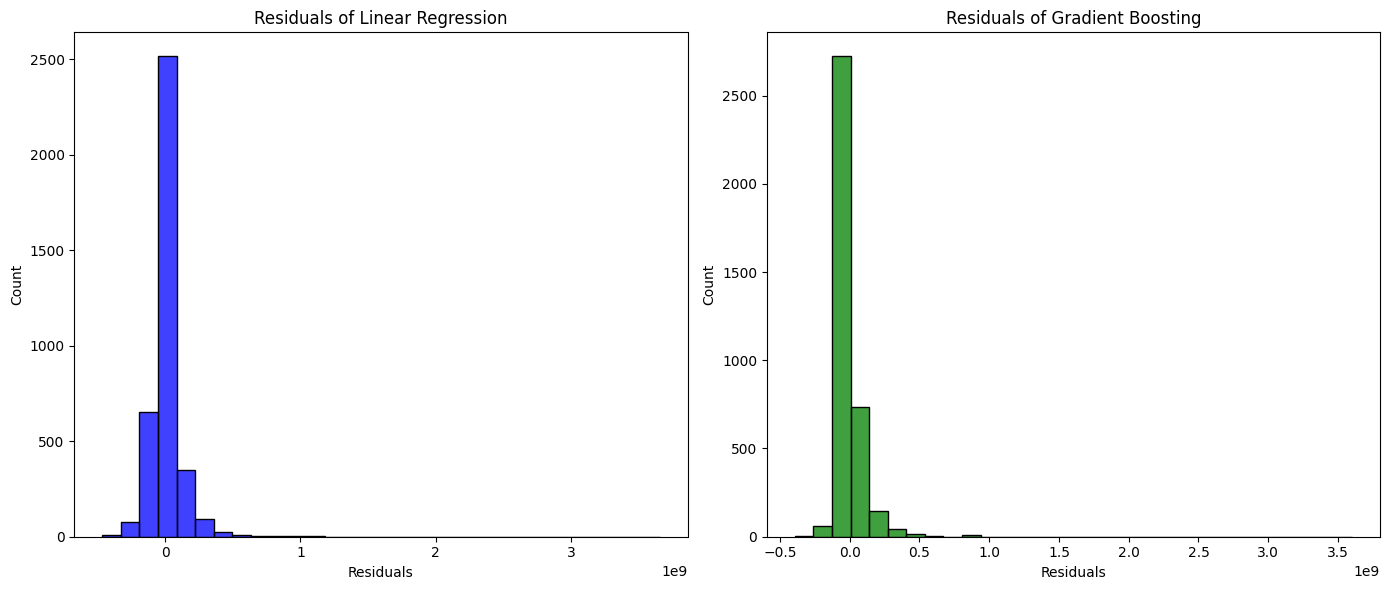

['gradient_boosting_regression_model.pkl']

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Load the dataset
df = pd.read_csv('world_bank_open.csv')

# Drop columns with a high percentage of missing values
df = df.drop(columns=[
    'mjsector1', 'mjsector2', 'mjsector3',
    'mjsector4', 'mjsector5', 'mjtheme1name', 'mjtheme2name', 'mjtheme3name',
    'mjtheme4name', 'mjtheme5name', 'Unnamed: 56', 'Country'
])

# Handle missing values
df = df.dropna(subset=['lendprojectcost', 'ibrdcommamt', 'idacommamt', 'totalamt', 'grantamt'])

# Convert columns with financial data to numeric types
financial_cols = ['lendprojectcost', 'ibrdcommamt', 'idacommamt', 'totalamt', 'grantamt']
df[financial_cols] = df[financial_cols].replace('[\$,]', '', regex=True).astype(float)

# Fill missing values in categorical columns with 'Unknown'
categorical_cols = ['lendinginstr', 'lendinginstrtype', 'envassesmentcategorycode', 'supplementprojectflg',
                    'productlinetype', 'projectstatusdisplay', 'status', 'borrower', 'impagency', 'sector',
                    'mjsector', 'goal', 'financier', 'location']
df[categorical_cols] = df[categorical_cols].fillna('Unknown')

# Convert categorical variables to one-hot encoding
categorical_features = categorical_cols + ['regionname']

preprocessor = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
], remainder='drop')

# Define features and target variable
X = df.drop(columns=['id', 'project_name', 'url', 'boardapprovaldate', 'board_approval_month', 'closingdate'])
y = df['totalamt']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocess the features using the preprocessor pipeline
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

# Standardize the features
scaler = StandardScaler(with_mean=False)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# ---- MODEL TRAINING ----
# Train Linear Regression Model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Train Gradient Boosting Regression Model
gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
gb_model.fit(X_train, y_train)

# ---- MODEL EVALUATION ----
# Predictions
y_pred_lr = lr_model.predict(X_test)
y_pred_gb = gb_model.predict(X_test)

# Calculate Metrics (MSE and R²)
mse_lr = mean_squared_error(y_test, y_pred_lr)
mse_gb = mean_squared_error(y_test, y_pred_gb)
r2_lr = r2_score(y_test, y_pred_lr)
r2_gb = r2_score(y_test, y_pred_gb)

print(f'Linear Regression MSE: {mse_lr}')
print(f'Linear Regression R²: {r2_lr}')

print(f'Gradient Boosting MSE: {mse_gb}')
print(f'Gradient Boosting R²: {r2_gb}')

# ---- MODEL VISUALIZATION ----
# Create a DataFrame for comparison
results_df = pd.DataFrame({
    'True Values': y_test,
    'Linear Regression Predictions': y_pred_lr,
    'Gradient Boosting Predictions': y_pred_gb
})

# Scatter plot for predictions vs true values
plt.figure(figsize=(14, 6))

# Plot Linear Regression
plt.subplot(1, 2, 1)
sns.scatterplot(x=results_df['True Values'], y=results_df['Linear Regression Predictions'], color='blue', label='Linear Regression')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.title('Linear Regression Predictions vs True Values')
plt.xlabel('True Values')
plt.ylabel('Predictions')

# Plot Gradient Boosting
plt.subplot(1, 2, 2)
sns.scatterplot(x=results_df['True Values'], y=results_df['Gradient Boosting Predictions'], color='green', label='Gradient Boosting')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.title('Gradient Boosting Predictions vs True Values')
plt.xlabel('True Values')
plt.ylabel('Predictions')

plt.tight_layout()
plt.show()

# Residual plots (errors)
plt.figure(figsize=(14, 6))

# Residuals for Linear Regression
plt.subplot(1, 2, 1)
sns.histplot(y_test - y_pred_lr, bins=30, color='blue')
plt.title('Residuals of Linear Regression')
plt.xlabel('Residuals')

# Residuals for Gradient Boosting
plt.subplot(1, 2, 2)
sns.histplot(y_test - y_pred_gb, bins=30, color='green')
plt.title('Residuals of Gradient Boosting')
plt.xlabel('Residuals')

plt.tight_layout()
plt.show()

# ---- SAVE MODELS ----
# Save the models using joblib
joblib.dump(lr_model, 'linear_regression_model.pkl')
joblib.dump(gb_model, 'gradient_boosting_regression_model.pkl')


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Define GAN components
class Generator(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, output_dim)
        )

    def forward(self, x):
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# Hyperparameters
input_dim = X_train.shape[1]
output_dim = 1
lr = 0.0002
num_epochs = 40

# Initialize models and move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = Generator(input_dim, output_dim).to(device)
discriminator = Discriminator(input_dim + output_dim).to(device)

# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=lr)
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr)

# Loss function
criterion = nn.BCELoss()

# Prepare data for GAN and move to GPU
X_train_tensor = torch.tensor(X_train.toarray(), dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).to(device)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Training loop for GAN
for epoch in range(num_epochs):
    for real_data, real_labels in train_loader:
        batch_size = real_data.size(0)

        # Move real data and labels to GPU
        real_data = real_data.to(device)
        real_labels = real_labels.view(-1, 1).to(device)

        # Real data
        real_input = torch.cat((real_data, real_labels), dim=1)
        real_target = torch.ones(batch_size, 1).to(device)

        # Fake data
        noise = torch.randn(batch_size, input_dim).to(device)
        fake_labels = generator(noise).detach()
        fake_input = torch.cat((noise, fake_labels), dim=1)
        fake_target = torch.zeros(batch_size, 1).to(device)

        # Train Discriminator
        optimizer_D.zero_grad()
        real_loss = criterion(discriminator(real_input), real_target)
        fake_loss = criterion(discriminator(fake_input), fake_target)
        d_loss = real_loss + fake_loss
        d_loss.backward()
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()
        generated_labels = generator(noise)
        g_input = torch.cat((noise, generated_labels), dim=1)
        g_loss = criterion(discriminator(g_input), real_target)
        g_loss.backward()
        optimizer_G.step()

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, D Loss: {d_loss.item()}, G Loss: {g_loss.item()}')

# Save the GAN models
torch.save(generator.state_dict(), 'gan_generator.pth')
torch.save(discriminator.state_dict(), 'gan_discriminator.pth')

# Generate synthetic data
with torch.no_grad():
    synthetic_noise = torch.randn(X_train.shape[0], input_dim).to(device)
    synthetic_labels = generator(synthetic_noise).cpu().numpy()  # Move back to CPU for further processing
    synthetic_data = np.hstack((synthetic_noise.cpu().numpy(), synthetic_labels))

# Augment original data with synthetic data
augmented_X_train = np.vstack((X_train.toarray(), synthetic_data[:, :-1]))
augmented_y_train = np.hstack((y_train, synthetic_data[:, -1]))


Fitting 5 folds for each of 108 candidates, totalling 540 fits
